<a href="https://colab.research.google.com/github/sumu97/Data-Science-Cheat-Code/blob/main/Kospi_Market_Analysis_sumu97.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#코스피 동향분석 및 예측 - sumu97

###개요
 - 코스피 지수의 동향을 예측하여, 선물옵션을 통한 단기적 수익실현 및 투자지표로서의 활용이 가능하도록 합니다.
 - 추후 동일한 모델을 부동산 시장 등에 적용시키기 위해, 데이터에 맞춰 쉽게 변형할 수 있도록 작성합니다.
 - 두 개 이상의 예측 모델을 활용하여 그 결과를 토대로 서로의 예측을 개선할 수 있게 합니다.
 - 아리마 분석으로 Feature 수치를 대략적으로 예측하고, 예측된 데이터를 토대로 Random Forest를 활용해 Target Value를 구합니다.

## 1. 데이터

In [2]:
%%capture
from google.colab import drive
import io
import pandas as pd
import sys

if 'google.colab' in sys.modules:
    # Install packages in Colab
    !pip install category_encoders==2.*
    !pip install pandas-profiling==2.*
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.activity.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fexperimentsandconfigs%20https%3a%2f%2fwww.googleapis.com%2fauth%2fphotos.native&response_type=code

Enter your authorization code:
4/1AX4XfWg7KQQwag2w9hoQxv7wug2hcabWpWUUD_oE2p0o4Fc0-ApvBKweW-A


In [3]:
# 데이터
import datetime
import numpy as np

def get_data(NAME,col):
  # 1. 데이터 가져오기
  df = pd.read_csv('drive/MyDrive/Project/Data_For_Kospi/' + NAME + '.csv')

  # 2. 종가, 거래량, 변동% 제외한 Feature 제거 (중복 Issue 가능성)
  df = df.drop(['오픈','고가','저가'], axis=1)

  # 3. 컬럼명 변경 (원본 데이터마다 Columns 다름, 오류처리구문 추가)
  columns_volp = ['date' , col + '_' + 'enpr' , col + '_' + 'volm' , col + '_' + 'chag']
  columns_volm = ['date' , col + '_' + 'enpr' , col + '_' + 'chag']
  try:
    df.columns = columns_volp
  except:
    df.columns = columns_volm

  # 4. 자료형 변경
  for col in df.columns:
    temp_list = []
    for i in df[col]:
      
      try:
        temp = i.replace('년','') # ER : SILVER ('sv_enpr',) 23.925 에서 에러발생 / float를 replace 하다보니 문제 / 츄라이로 넘겨서 해결
        temp = temp.replace('월','')
        temp = temp.replace('일','')
        temp = temp.replace(' ','-') # 수정 / Debug
        temp = temp.replace(',','')
        temp = temp.replace('K','000')
        temp = temp.replace('%','')
      except:
        temp_list.append(i) # 첨부터 float인 자료형을 list에 저장 / ER : append(temp) 해놓고 뭐가문젠지 한참 찾았네..
        continue # ER : 컬럼에 리스트 적용시 길이가 달라 에러발생 / 아래 츄라이문 하면서 중복적용된게 문제 / 컨티뉴로 돌려보내서 해결
        # ER : 뒷쪽 구문 먹어버려서 'sv_enpr' 에 의미가 다른 값이 들어감
      try:
        temp = float(temp)
        temp_list.append(temp) # float 로 변경된 자료형을 list에 저장
      except:
        try:
          #print(col, i, temp)
          temp = datetime.datetime.strptime(temp, '%Y-%m-%d').date()
          temp_list.append(temp) # datetime 로 변경된 자료형을 list에 저장
        except:
          temp = np.nan
          temp_list.append(temp) # NaN 으로 변경된 자료형을 list에 저장
    df[col] = temp_list # 변경된 리스트를 col 에 저장

  print(df.shape) # Debug code / 으아아 같은기간 긁었는데 뭐가이렇게 달라

  # 5. 데이터프레임으로 반환
  return df

gd = get_data('GOLD','gd') # 금 시세
sv = get_data('SILVER','sv') # 은 시세
ob = get_data('OIL_BRENT','ob') # 브렌트유 시세
ow = get_data('OIL_WTI','ow') # WTI유 시세
sp = get_data('S&P','sp') # 미국 증시 S&P 500 지수
kd = get_data('KOSDAQ','kd') # 코스닥
kp = get_data('KOSPI','kp') # 코스피(Target)
kr = get_data('KR10','kr') # 한국 10년 국채 수익률
us = get_data('US10','us') # 미국 10년 국채 수익률
jk = get_data('JPY_KRW','jk') # 엔 - 원 환율
uk = get_data('USD_KRW','uk') # 달러 - 원 환율

gd.set_index('date', inplace = True)
sv.set_index('date', inplace = True)
ob.set_index('date', inplace = True)
ow.set_index('date', inplace = True)
sp.set_index('date', inplace = True)
kd.set_index('date', inplace = True)
kp.set_index('date', inplace = True)
kr.set_index('date', inplace = True)
us.set_index('date', inplace = True)
jk.set_index('date', inplace = True)
uk.set_index('date', inplace = True)

df = gd.join(sv, how='outer').join(ob, how='outer').join(ow, how='outer').join(sp , how='outer').join(kd , how='outer').join(kp , how='outer').join(kr , how='outer').join(us , how='outer').join(jk , how='outer').join(uk , how='outer')

(2642, 4)
(3140, 4)
(2604, 4)
(2635, 4)
(2537, 4)
(2485, 4)
(2484, 4)
(3168, 3)
(3012, 3)
(2632, 3)
(2632, 3)


In [4]:
# 결측치가 너무 많은 (1500 이상인) Feature 삭제
df = df.drop(['sp_volm','kd_volm','kp_volm'], axis = 1)

In [5]:
# 나머지 결측치는 선형 보간 (interpolation)
df_intp = df.interpolate()

In [6]:
# 보간 후에도 결측치 남아있는 행 삭제 (상위 2행, 시계열 데이터에 영향 주지 않음)
df = df_intp.dropna()

In [7]:
# 중복 값 있는지 확인 -> 없음
df.T.duplicated()

gd_enpr    False
gd_volm    False
gd_chag    False
sv_enpr    False
sv_volm    False
sv_chag    False
ob_enpr    False
ob_volm    False
ob_chag    False
ow_enpr    False
ow_volm    False
ow_chag    False
sp_enpr    False
sp_chag    False
kd_enpr    False
kd_chag    False
kp_enpr    False
kp_chag    False
kr_enpr    False
kr_chag    False
us_enpr    False
us_chag    False
jk_enpr    False
jk_chag    False
uk_enpr    False
uk_chag    False
dtype: bool

## 2. Feature 시각화

In [27]:
df.columns[0]

'gd_enpr'

In [22]:
df_enpr = df[df.columns[0]]

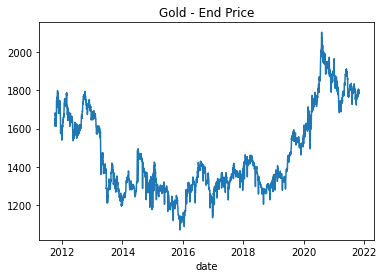

In [74]:
import matplotlib.pyplot as plt
df_enpr.plot()
plt.title('Gold - End Price')
plt.show()

In [75]:
step = 50 # 테스트 데이터 분리 할 일자 수
test_df = df_enpr.drop(df_enpr.index[-1 * step :-1])
test_df = test_df.drop(test_df.index[-1])
test_df

date
2011-10-04    1614.700000
2011-10-05    1640.300000
2011-10-06    1651.900000
2011-10-07    1634.500000
2011-10-09    1652.050000
                 ...     
2021-09-08    1793.500000
2021-09-09    1800.000000
2021-09-10    1792.100000
2021-09-11    1792.866667
2021-09-12    1793.633333
Name: gd_enpr, Length: 3459, dtype: float64

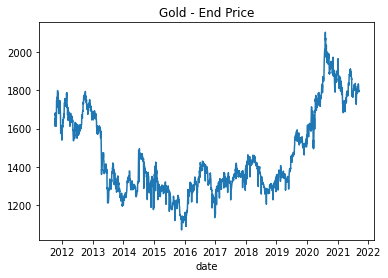

In [76]:
import matplotlib.pyplot as plt
test_df.plot()
plt.title('Gold - End Price')
plt.show()

## 3. ARIMA 분석

In [77]:
from statsmodels.tsa.arima_model import ARIMA
import statsmodels.api as sm

model = ARIMA(test_df.values, order = (5,1,2))
# AR = 3, 차분 = 1, MA = 2 파라미터로 ARIMA 모델을 학습한다.

In [78]:

# ARIMA 모델 학습
model_fit = model.fit(trend = 'c', full_output = True, disp = True)
print(model_fit.summary())

                             ARIMA Model Results                              
Dep. Variable:                    D.y   No. Observations:                 3458
Model:                 ARIMA(5, 1, 2)   Log Likelihood              -14776.119
Method:                       css-mle   S.D. of innovations             17.358
Date:                Wed, 03 Nov 2021   AIC                          29570.238
Time:                        15:15:18   BIC                          29625.574
Sample:                             1   HQIC                         29589.999
                                                                              
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0490      0.196      0.250      0.803      -0.336       0.434
ar.L1.D.y     -0.1407      0.153     -0.922      0.357      -0.440       0.158
ar.L2.D.y      0.5148      0.117      4.416      0.0

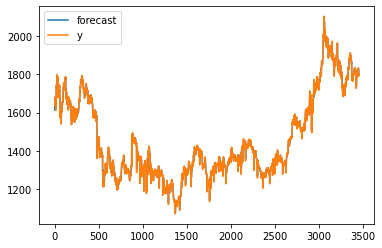

In [79]:
# 학습 데이터에 대한 예측 결과
fig = model_fit.plot_predict()

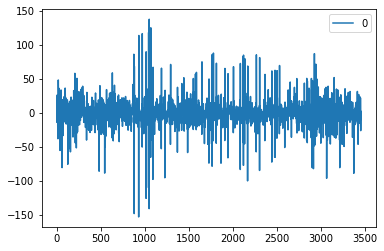

In [80]:
# 실제값과 예측값 사이의 오차 변동
residuals = pd.DataFrame(model_fit.resid)
residuals.plot()

In [81]:
# 모델 평가
forecast_data = model_fit.forecast(steps=step) 

test_df1 = df_enpr[len(df_enpr) - step:]
test_df1

date
2021-09-13    1794.400000
2021-09-14    1807.100000
2021-09-15    1794.800000
2021-09-16    1756.700000
2021-09-17    1751.400000
2021-09-18    1755.533333
2021-09-19    1759.666667
2021-09-20    1763.800000
2021-09-21    1778.200000
2021-09-22    1778.800000
2021-09-23    1749.800000
2021-09-24    1751.700000
2021-09-25    1751.800000
2021-09-26    1751.900000
2021-09-27    1752.000000
2021-09-28    1737.500000
2021-09-29    1722.900000
2021-09-30    1757.000000
2021-10-01    1758.400000
2021-10-02    1761.466667
2021-10-03    1764.533333
2021-10-04    1767.600000
2021-10-05    1760.900000
2021-10-06    1761.800000
2021-10-07    1759.200000
2021-10-08    1757.400000
2021-10-09    1756.833333
2021-10-10    1756.266667
2021-10-11    1755.700000
2021-10-12    1759.300000
2021-10-13    1794.700000
2021-10-14    1797.900000
2021-10-15    1768.300000
2021-10-16    1767.433333
2021-10-17    1766.566667
2021-10-18    1765.700000
2021-10-19    1770.500000
2021-10-20    1784.900000
2021-10

In [82]:
# 마지막 5월의 예측 데이터
pred_y = forecast_data[0].tolist()

# 실제 5월의 데이터
test_y = test_df1.values

# 마지막 5월의 예측 데이터 최소값
pred_y_lower = []

# 마지막 5월의 예측 데이터 최대값
pred_y_upper = []

In [83]:
for lower_upper in forecast_data[2]:
    lower = lower_upper[0]
    upper = lower_upper[1]
    pred_y_lower.append(lower)
    pred_y_upper.append(upper)

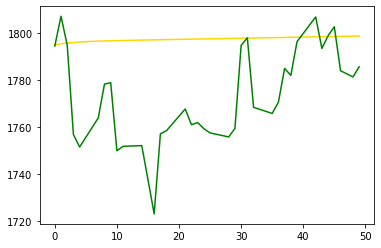

In [85]:
# 모델이 예측한 가격 그래프
plt.plot(pred_y, color = 'gold')

# 모델이 예측한 최저 가격 그래프
#plt.plot(pred_y_lower, color = 'red')

# 모델이 예측한 최고 가격 그래프
#plt.plot(pred_y_upper, color = 'blue')

# 실제 가격 그래프
plt.plot(test_y, color = 'green')